In [1]:
# Import libraries
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer 
from sklearn.impute import SimpleImputer
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVC
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
    cohen_kappa_score,
    roc_auc_score,
)

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import pearsonr
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
from sklearn.naive_bayes import GaussianNB


ERROR! Session/line number was not unique in database. History logging moved to new session 236


### Dataset 1: Power Consumption in a Steel Industry

In [2]:
# Load dataset
steel_data = pd.read_csv("steel_industry_data.csv")


Checking the dataset

In [3]:
print(steel_data.head())
print(steel_data.describe())

               date  Usage_kWh  Lagging_Current_Reactive.Power_kVarh  \
0  01/01/2018 00:15       3.17                                  2.95   
1  01/01/2018 00:30       4.00                                  4.46   
2  01/01/2018 00:45       3.24                                  3.28   
3  01/01/2018 01:00       3.31                                  3.56   
4  01/01/2018 01:15       3.82                                  4.50   

   Leading_Current_Reactive_Power_kVarh  CO2(tCO2)  \
0                                   0.0        0.0   
1                                   0.0        0.0   
2                                   0.0        0.0   
3                                   0.0        0.0   
4                                   0.0        0.0   

   Lagging_Current_Power_Factor  Leading_Current_Power_Factor   NSM  \
0                         73.21                         100.0   900   
1                         66.77                         100.0  1800   
2                         70.

In [4]:
steel_data.head()

date  Usage_kWh  Lagging_Current_Reactive.Power_kVarh  \
0  01/01/2018 00:15       3.17                                  2.95   
1  01/01/2018 00:30       4.00                                  4.46   
2  01/01/2018 00:45       3.24                                  3.28   
3  01/01/2018 01:00       3.31                                  3.56   
4  01/01/2018 01:15       3.82                                  4.50   

   Leading_Current_Reactive_Power_kVarh  CO2(tCO2)  \
0                                   0.0        0.0   
1                                   0.0        0.0   
2                                   0.0        0.0   
3                                   0.0        0.0   
4                                   0.0        0.0   

   Lagging_Current_Power_Factor  Leading_Current_Power_Factor   NSM  \
0                         73.21                         100.0   900   
1                         66.77                         100.0  1800   
2                         70.28                         100.0  2700   
3                         68.09                         100.0  3600   
4                         64.72                         100.0  4500   

  WeekStatus Day_of_week   Load_Type  
0    Weekday      Monday  Light_Load  
1    Weekday      Monday  Light_Load  
2    Weekday      Monday  Light_Load  
3    Weekday      Monday  Light_Load  
4    Weekday      Monday  Light_Load

Data Cleaning and Normalization

In [5]:
# Remove duplicates

steel_data = steel_data.drop_duplicates()

# Normalize numeric columns
numeric_steel_data = steel_data.select_dtypes(include=['float64', 'int64']).columns
steel_data[numeric_steel_data] = (steel_data[numeric_steel_data] - steel_data[numeric_steel_data].mean()) / steel_data[numeric_steel_data].std()



In [6]:
# Correlation heatmap
numeric_steel_data = steel_data.select_dtypes(include=['float64', 'int64'])
corr = numeric_steel_data.corr()
fig_corr = px.imshow(corr, title = 'Correlation Heatmap', 
                     width=800,
                     height=600, 
                     color_continuous_scale = 'Viridis')
fig_corr.show()

Examining the data spread in major columns

In [7]:
# List of selected columns to plot
selected_columns = ['Usage_kWh', 
                    'Lagging_Current_Reactive.Power_kVarh',
                    'CO2(tCO2)','Lagging_Current_Power_Factor',
                    'NSM']  # Replace with your desired column names

# Loop through the selected columns and plot their distributions
for col in selected_columns:
    if col in steel_data.columns and steel_data[col].dtype != 'object':
        fig_distribution = px.histogram(
            steel_data, 
            x=col, 
            nbins=50, 
            title=f'Distribution of {col}'
        )
        fig_distribution.show()
    else:
        print(f"Column '{col}' is not numeric or does not exist in the dataset.")


Copying the original data frame in a new temporary dataframe for scatterplot

In [8]:
new_steel_data = steel_data

Aggregating the date column into month, to show in the scatter plot

In [9]:
# Convert 'date' column to datetime if not already
new_steel_data['date'] = pd.to_datetime(new_steel_data['date'])

# Group by month and calculate monthly sums or means
new_steel_data_monthly = new_steel_data.resample('M', on='date').mean().reset_index()

C:\Users\sidsdesh\AppData\Local\Temp\ipykernel_20248\1697585663.py:5: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



In [10]:
fig = px.scatter(new_steel_data_monthly, 
                 x='date', 
                 y='Usage_kWh', 
                 color='CO2(tCO2)',
                 title='Monthly Energy Usage vs CO2 Emissions',
                 labels={'date': 'Month', 'Usage_kWh': 'Energy Usage (Monthly Average)'}
                )
fig.show()

Checking for outliers through Box plot

In [11]:
fig = px.box(steel_data, y='Usage_kWh',
             labels={'Usage_kWh': 'Energy Usage (kWh)'},
             title="Energy Usage (kWh) Outliers")

fig.update_layout(yaxis = dict(
    tickmode = 'array', tickvals = [0,1],
    ticktext = ['Energy Usage (kWh) (0) - Normal', 'Energy Usage (kWh) (1) - Outlier']
))

fig.show()


### Modelling

#### i) Linear Regression Model

Data Preparation

In [12]:
# Convert 'date' column to numeric (if not already done)
steel_data['date'] = pd.to_datetime(steel_data['date'])
steel_data['date'] = steel_data['date'].astype('int64') // 10**9  # Convert to seconds



In [13]:
# Encode categorical features
steel_data = pd.get_dummies(steel_data, columns=['WeekStatus', 'Day_of_week', 'Load_Type'], drop_first=True)


Defining target and features

In [14]:
X_lr = steel_data.drop(columns=['Usage_kWh'])  # Features
y_lr = steel_data['Usage_kWh']                # Target



Split into training and testing sets


In [15]:
X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(X_lr, y_lr, test_size=0.2, random_state=42)


In [16]:

linear_model = LinearRegression()
linear_model.fit(X_train_lr, y_train_lr)

LinearRegression()

In [17]:
# Predict on test data
y_pred_linear = linear_model.predict(X_test_lr)

#### Evaluate Linear Regression


In [18]:
print("Linear Regression Performance Metrics:")
print("RMSE:", np.sqrt(mean_squared_error(y_test_lr, y_pred_linear)))
print("R2 Score:", r2_score(y_test_lr, y_pred_linear))
print("MAPE:", mean_absolute_percentage_error(y_test_lr, y_pred_linear))
print("-" * 50)


Linear Regression Performance Metrics:
RMSE: 0.12627673702609699
R2 Score: 0.9843094343938399
MAPE: 0.1694044962953671
--------------------------------------------------


#### ii) Applying K-Nearest Neighbors (KNN) for Regression

Copying earlier variables into new ones for simplicity and avoiding confusion

In [19]:
X_knn = X_lr
y_knn =y_lr


X_train_knn, X_test_knn, y_train_knn, y_test_knn = train_test_split(X_knn, y_knn, test_size=0.2, random_state=23270110)

In [20]:
# Initialize and train the KNN model
knn_model = KNeighborsRegressor(n_neighbors=5)  
knn_model.fit(X_train_knn, y_train_knn)



KNeighborsRegressor()

In [21]:
# Predict on the test data
y_pred_knn = knn_model.predict(X_test_knn)

In [22]:
# Evaluate KNN
print("K-Nearest Neighbors (KNN) Regression Performance Metrics:")
print("RMSE:", np.sqrt(mean_squared_error(y_test_knn, y_pred_knn)))
print("R2 Score:", r2_score(y_test_knn, y_pred_knn))
print("MAPE:", mean_absolute_percentage_error(y_test_knn, y_pred_knn))
print("-" * 50)

K-Nearest Neighbors (KNN) Regression Performance Metrics:
RMSE: 0.40764994587355957
R2 Score: 0.8297633698243184
MAPE: 0.4753757045709568
--------------------------------------------------


#### Analyzing the model performances

In [24]:
metrics = {
    "Linear Regression": {
        "RMSE": 0.12627673702609699, 
        "R2": 0.9843094343938399, 
        "MAPE": 0.1694044962953671   

    },
    "KNN": {
        "RMSE": 0.40764994587355957,  
        "R2": 0.8297633698243184, 
        "MAPE": 0.4753757045709568  
    }
}

# Print metrics
for model, metric_values in metrics.items():
    print(f"Performance of {model}:")
    for metric_name, value in metric_values.items():
        print(f"  {metric_name}: {value:.4f}")
    print()

Performance of Linear Regression:
  RMSE: 0.1263
  R2: 0.9843
  MAPE: 0.1694

Performance of KNN:
  RMSE: 0.4076
  R2: 0.8298
  MAPE: 0.4754



#### Scatter Plots to visualize the model performances

In [42]:
# Plot comparison of models (scatter plot for predictions vs actuals)

plt.figure(figsize=(15, 8), dpi = 120)


<Figure size 1800x960 with 0 Axes>

<Figure size 1800x960 with 0 Axes>

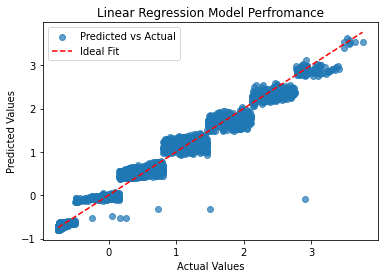

In [47]:
# Scatter plot for Linear Regression
#plt.subplot(1, 2, 1)
plt.scatter(y_test_lr, y_pred_linear, alpha=0.7, label="Predicted vs Actual")
plt.plot([y_test_lr.min(), y_test_lr.max()], [y_test_lr.min(), y_test_lr.max()], 'r--', label="Ideal Fit")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Linear Regression Model Perfromance")
plt.legend()

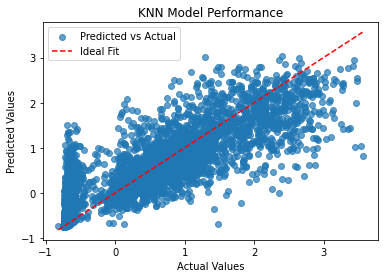

In [46]:
# Scatter plot for KNN
#plt.subplot(1, 2, 2)
plt.scatter(y_test_knn, y_pred_knn, alpha=0.7, label="Predicted vs Actual")
plt.plot([y_test_knn.min(), y_test_knn.max()], [y_test_knn.min(), y_test_knn.max()], 'r--', label="Ideal Fit")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("KNN Model Performance")
plt.legend()